<a href="https://colab.research.google.com/github/sachin16495/churn_prediction_and_sentimetal_analysis/blob/master/Tweet_Sentiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this imporvisation I used fast.ai library for the sentimental analysis Its deep lstm with Atttention layer based library which is used for text modeling.In this assignment with help of fasttext I initially did languge modelling and after use the same in the training data in the pickle format

In [0]:
import pandas as pd

In [0]:
df = pd.read_csv('sentiment.tsv',delimiter='\t',encoding='utf-8',names=["Sentiment", "Tweets"])

In [206]:
df.head()

,Sentiment,Tweets
0,neg,"@jamielewislewis i cant believe it, it really ..."
1,pos,having a vodka tonic and looking forward to go...
2,pos,@ddlovatofans1neg1 Could you follow me please....
3,pos,@jordanknight for once.................. PLEAS...
4,neg,Had a dream about a walk in fast food resturau...


In [0]:
classes={u'neg':0,u'pos':1}
classesa=['pos','neg']

#One Hot encoding of labels
#labrl=[classes[leb] for leb in sentiment]

#sentiment=sentiment_df["Sentiment"]
#sentiment_text=sentiment_df["Tweets"]=[clean(txt) for txt in sentiment_df["Tweets"]]
df['Sentiment']=[classes[leb] for leb in df['Sentiment']]

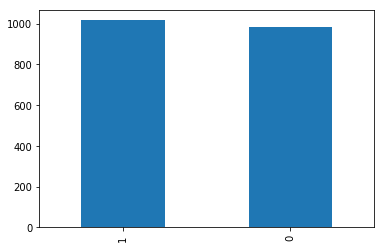

In [219]:
df['Sentiment'].value_counts().plot(kind='bar')

In [208]:
df.head()

,Sentiment,Tweets
0,0,"@jamielewislewis i cant believe it, it really ..."
1,1,having a vodka tonic and looking forward to go...
2,1,@ddlovatofans1neg1 Could you follow me please....
3,1,@jordanknight for once.................. PLEAS...
4,0,Had a dream about a walk in fast food resturau...


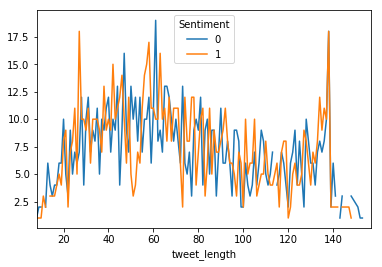

In [220]:
df['tweet_length'] = df['Tweets'].apply(len)
df.groupby(['tweet_length', 'Sentiment']).size().unstack().plot(kind='line', stacked=False)

In [0]:
tweet_data = df.copy().sample(2000, random_state=42)

In [0]:
tweet_data=tweet_data[['Sentiment','Tweets']]

In [0]:
tweet_data.dropna(inplace=True)

In [0]:
from fastai.text import *

Here we have created databunch for our model

In [0]:
data_lm = (TextList.from_df(tweet_data, cols='Tweets').split_by_rand_pct(0.1).label_for_lm().databunch())

In [0]:
data_lm.show_batch(2)

idx,text
0,"goes xxbos break my xxunk tweets xxbos xxunk good luck xxrep 5 x xxbos yes the sun has moved . off to xxunk in the sun , i love england when its xxunk and xxunk haha xxunk x xxbos never will the xxunk up of the iphone take so long xxbos xxmaj see yeah later . i have to go to a party . xxmaj xxunk xxunk for now ."
1,"my alarm xxunk , it said xxunk ! and it 's actually xxunk , so much for a lay in xxbos xxunk thanks ! xxbos @ work ! xxmaj watching true blood ! xxbos xxunk oh i m not xxunk ... but i ve moved into the xxunk for my xxunk . xxbos xxunk in about xxunk ... so wish i had someone to share em with xxbos i miss"


In [214]:
data_lm.save('data_lm.pkl')

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type CrossEntropyLoss. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Here we set the leraner parmeter in our case it is Transformer based LSTM

In [215]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.5)

learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


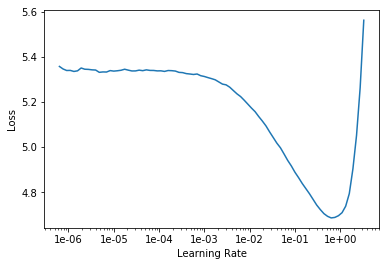

In [216]:
learn.recorder.plot()


In [217]:
learn.fit_one_cycle(1, 3e-02, moms=(0.8, 0.7))


epoch,train_loss,valid_loss,accuracy,time
0,4.793490,4.058290,0.227679,00:02


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


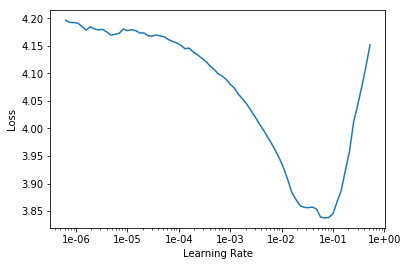

In [218]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot(skip_end=15)

In [221]:
learn.fit_one_cycle(10, 3e-04, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.174642,3.963422,0.247098,00:03
1,4.094451,3.842378,0.264732,00:03
2,4.027578,3.759416,0.273884,00:03
3,3.958587,3.722546,0.275446,00:03
4,3.894624,3.701369,0.279241,00:03
5,3.843980,3.701565,0.272098,00:03
6,3.793103,3.674749,0.284152,00:03
7,3.748014,3.677370,0.279241,00:03
8,3.714307,3.672251,0.280357,00:03
9,3.684848,3.670398,0.282589,00:03


In [0]:
learn.save_encoder('fine_tuned_enc')

In [0]:
mean_fpr = np.linspace(0,1,100)
n_split=10
cvscores = []


In [0]:
from sklearn.model_selection import KFold

In [0]:
kf = KFold(n_splits = n_split, shuffle = True, random_state = 2)


In [0]:
result1=next(kf.split(tweet_data))

In [0]:
result1

(array([   0,    1,    2,    3, ..., 1996, 1997, 1998, 1999]),
 array([   4,   45,   52,   65, ..., 1940, 1945, 1977, 1980]))

In [228]:
len(list(tweet_data.index))

2000

In [0]:
len(list(result1[0]))

1800

In [0]:
len(tweet_data[(tweet_data.index).isin(list(result1[0]))])

1799

In [0]:
data_clas = (TextList.from_df((tweet_data[(tweet_data.index).isin(list(result1[0]))]) , cols='Tweets', vocab=data_lm.vocab)
   .split_by_rand_pct(0.2)
   .label_from_df('Sentiment')
   .databunch())
  

In [0]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

In [0]:
from numpy import interp

In [0]:
tprs=[]
aucs=[]
i=0

In [0]:
next(kf.split(tweet_data))

(array([   0,    1,    2,    3, ..., 1996, 1997, 1998, 1999]),
 array([   4,   45,   52,   65, ..., 1940, 1945, 1977, 1980]))

Apply Kfold on the data and prepare variable for roc and auc curve

In [233]:
for result in next(kf.split(tweet_data)):
  print(result)
  print("----------")
  data_clas = (TextList.from_df((tweet_data[(tweet_data.index).isin(list(result))]), cols='Tweets', vocab=data_lm.vocab)
   .split_by_rand_pct(0.2)
   .label_from_df('Sentiment')
   .databunch())
  learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
  learn.load_encoder('fine_tuned_enc')
  learn.freeze_to(-3)
  learn.fit_one_cycle(5, slice(5e-03/(2.6**4),5e-03), moms=(0.8,0.7))
  res=tweet_data[~((tweet_data.index).isin(list(result)))]["Tweets"].apply(lambda row: int((learn.predict(row)[0])))
  #print(res)
  label=tweet_data[~((tweet_data.index).isin(list(result)))]["Sentiment"]
  fpr, tpr, t = roc_curve(np.round(label),res)
  tprs.append(interp(mean_fpr, fpr, tpr))
  roc_auc = auc(fpr, tpr)
  aucs.append(roc_auc)
  i= i+1


epoch,train_loss,valid_loss,accuracy,time
0,0.742223,0.691921,0.575000,00:00
1,0.704296,0.691930,0.550000,00:00
2,0.674138,0.698534,0.500000,00:00
3,0.628400,0.702621,0.450000,00:00
4,0.581039,0.706917,0.500000,00:00


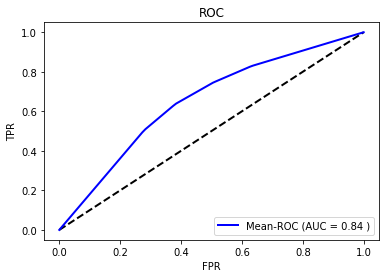

In [247]:
plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')
mean_tpr = np.mean(tprs, axis=0)
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='blue',
         label=r'Mean-ROC (AUC = %0.2f )' % (mean_auc),lw=2, alpha=1)

plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC')
plt.legend(loc="lower right")

plt.show()
#print(scores)